### Imports

In [1]:
import os
import math
from six.moves import cPickle as cp

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set()

In [2]:
import mixtureofconcave as subm
import determinantal as logsubm
import plottingtools

In [4]:
data_dir = os.getcwd() + "/imagesumm/"

In [35]:
idx = 4

### Plottingtools

In [39]:
def plotall(direc, n):
    ncol = np.floor(np.sqrt(n)); nrow = n//ncol + 1
    
    plt.figure(figsize=(20,20))
    for i in range(n):
        plt.subplot(nrow, ncol, i+1)
        img = plt.imread(direc + "{}.jpg".format(i+1))
        plt.axis("off")
        plt.imshow(img)

In [44]:
def plotsumm(direc, n, S):
    k = len(S)
    
    plt.figure(figsize=(2*k,2))
    for i in range(k):
        plt.subplot(1, k, i+1)
        img = plt.imread(direc + "{}.jpg".format(S[i]+1))
        plt.axis("off")
        plt.imshow(img)
        

In [47]:
# plotall(data_dir+"set{}/".format(idx+1), 100)
# plotsumm(data_dir+"set{}/".format(idx+1), 100, np.random.choice(100, 10))

### Get feature matrix

In [48]:
from scipy import io
proc_data = {} #empty dictionary
io.loadmat(data_dir+'processed_data.mat', mdict=proc_data);

In [49]:
X = proc_data["all_Feature_Vec"]

In [54]:
X = X[:,idx][0]

### Get learnt weights

In [17]:
resultfile = "w_collection{}_1.save".format(idx+1)
opfile = open(data_dir + resultfile, "rb")
resultdict = cp.load(opfile, encoding="bytes")
opfile.close()

resultdict.keys()

dict_keys([b'Cinv', b'Performance', b'Yvec', b'Queried_Scores', b'Queried_Summaries'])

In [18]:
Cinv = resultdict[b'Cinv']
Yvec = resultdict[b'Yvec']

In [23]:
wlearnt = np.dot(np.linalg.inv(Cinv), Yvec).flatten()

In [68]:
mufile = open(data_dir + "w_collection{}_vr_proto3.save".format(idx+1), "rb")
wlearnt = cp.load(mufile)["mu"]
mufile.close()

### Summarize

In [55]:
[n_samples, m_features] = X.shape

In [94]:
#%% Grouping for collection5 (idx=4)
assignA = np.array([
                    0,0,0,0,0,0,0,0,
                    8,
                    1,1,1,1,1,1,1,1,1,1,1,1,1,
                    2,2,2,2,2,2,2,
                    1,1,1,1,1,1,1,1,1,1,1,
                    3,3,3,3,3,3,3,3,3,3,3,3,3,3,
                    4,4,
                    5,5,5,5,
                    4,4,4,4,4,4,4,4,4,
                    5,5,5,5,5,5,5,
                    6,6,6,6,6,
                    7,7,7,7,7,7,
                    8,8,8,8,8,8,8,
                    9,9,9,9,
                    10,10
                   ])

assignB = np.array([
                    0,0,0,0,0,0,0,0,
                    6,
                    1,1,1,1,1,1,1,1,1,1,1,1,1,
                    2,2,2,2,2,2,2,
                    1,1,1,1,1,1,1,1,1,1,1,
                    2,2,2,2,2,2,2,2,2,2,2,2,2,2,
                    3,3,
                    3,3,3,3,
                    3,3,3,3,3,3,3,3,3,
                    3,3,3,3,3,3,3,
                    4,4,4,4,4,
                    5,5,5,5,5,5,
                    6,6,6,6,6,6,6,
                    7,7,7,7,
                    7,7
                   ])

In [115]:
#%% Quotas for collection5 (idx=4), assignA

p_groups = len(np.unique(assignA))
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

Memvec = np.eye(p_groups)[assignA].astype(int)
print(np.sum(Memvec, axis=0))

quo = np.array([1,1,1,1,1,0,1,1,1,1,0])

k_budget = 15

[ 8 24  7 14 11 11  5  6  8  4  2]


In [101]:
#%% Quotas for collection5 (idx=4), assignB

p_groups = len(np.unique(assignB))
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

Memvec = np.eye(p_groups)[assignB].astype(int)
print(np.sum(Memvec, axis=0))

quo = np.array([1,0,1,1,1,1,1,0])

k_budget = 10

Objective without quota 0.4220681996703154
Objective with quota 0.4221577731469554
Objective of random selection 0.3536492537834365


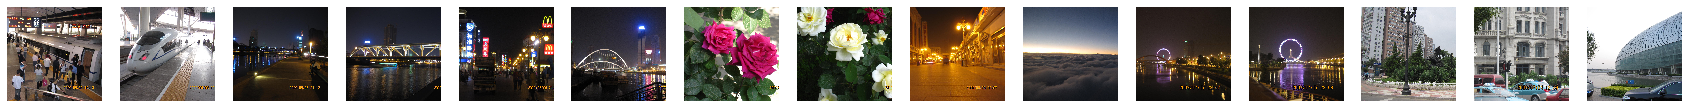

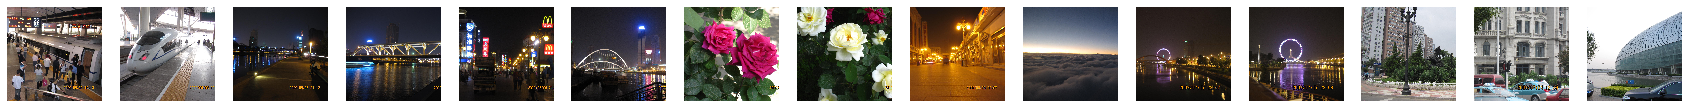

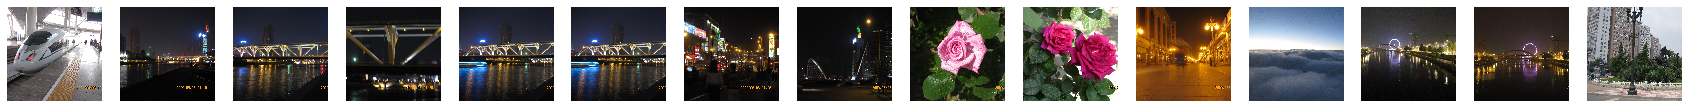

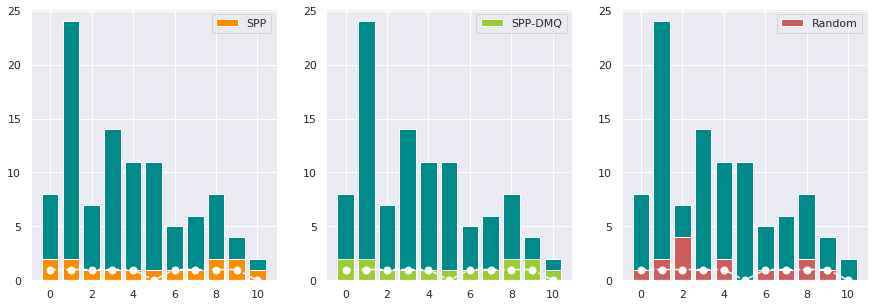

In [116]:
S_s, objectives_s = subm.greedygains_submod(None, X, wlearnt, k_budget)
S_sq, objectives_sq = subm.greedyDMquota_submod(None, X, wlearnt, Memvec, quo, k_budget)
S_r = np.random.choice(n_samples, k_budget)
objective_sr = subm.submodgains(X, np.sum(X[S_r,:], axis=0), 0, None, wlearnt)

print("Objective without quota", objectives_s[-1])
plotsumm(data_dir+"set{}/".format(idx+1), n_samples, np.sort(S_s))
print("Objective with quota", objectives_sq[-1])
plotsumm(data_dir+"set{}/".format(idx+1), n_samples, np.sort(S_sq))
print("Objective of random selection", objective_sr)
plotsumm(data_dir+"set{}/".format(idx+1), n_samples, np.sort(S_r))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_s, "darkorange", "SPP")
plt.subplot(1,3,2)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_sq, "yellowgreen", "SPP-DMQ")
plt.subplot(1,3,3)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_r, "indianred", "Random")

In [119]:
print(S_s)
print(S_sq)

[39 79 48 71  4 92 99 82 28 65 97 12 89  0 94]
[39 79 48  4 65 92 82 27 94 71 99 12 97 89  0]


In [120]:
print(np.sort(S_s))
print(np.sort(S_sq))

[ 0  4 12 28 39 48 65 71 79 82 89 92 94 97 99]
[ 0  4 12 27 39 48 65 71 79 82 89 92 94 97 99]


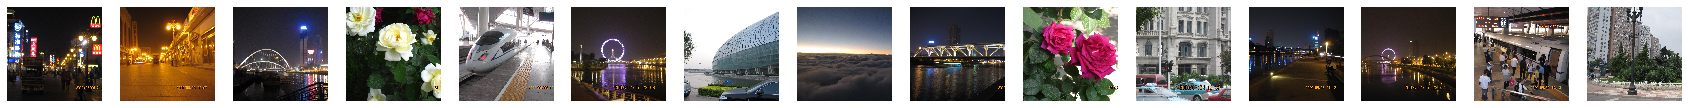

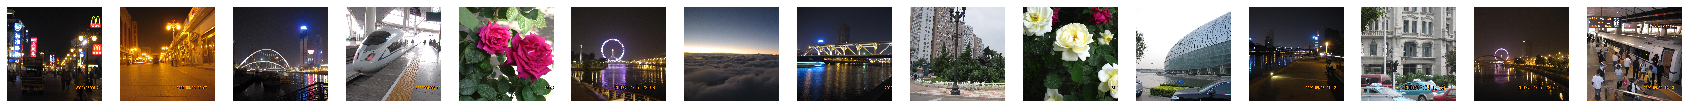

In [121]:
plotsumm(data_dir+"set{}/".format(idx+1), n_samples, S_s)
plotsumm(data_dir+"set{}/".format(idx+1), n_samples, S_sq)

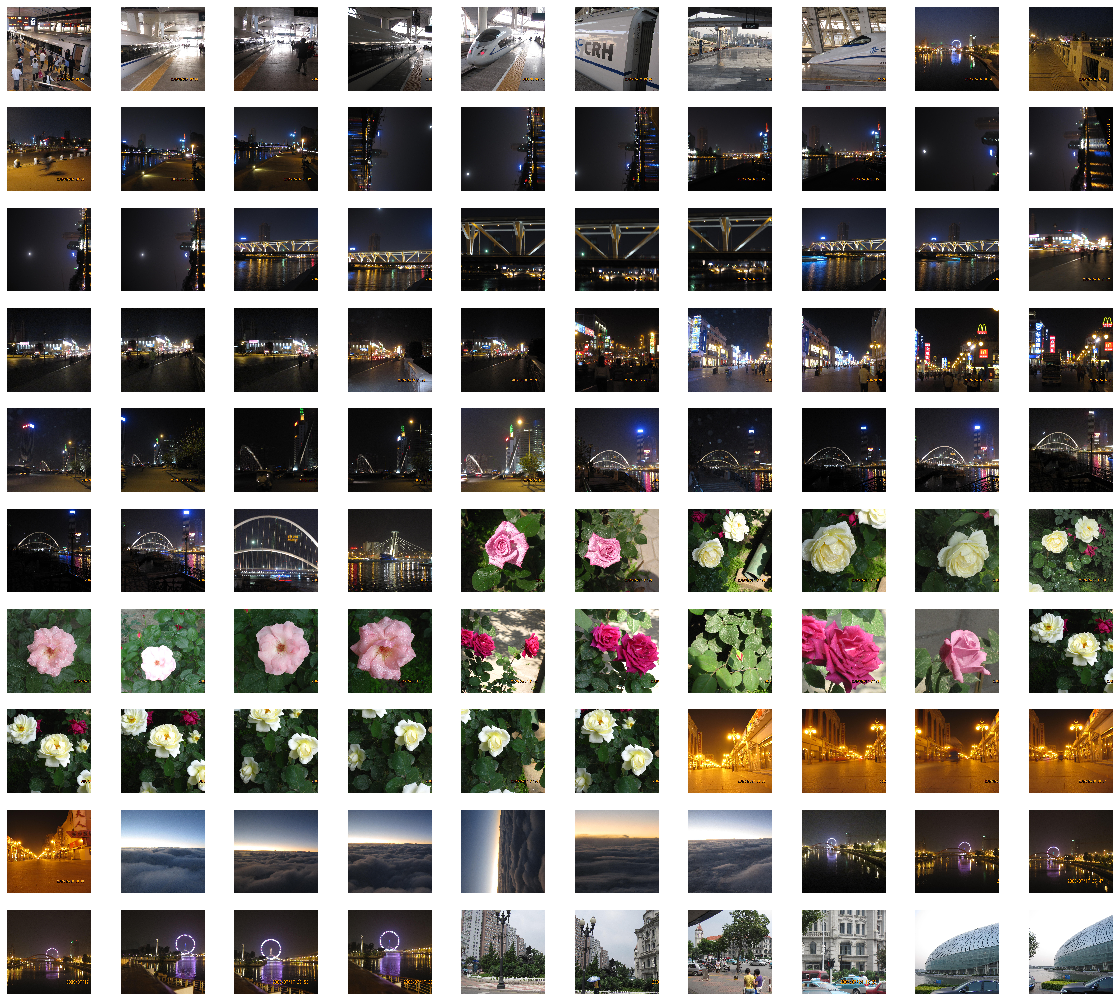

In [77]:
plotall(data_dir+"set{}/".format(idx+1), 100)